# Data cleanup notebook
This notebook is meant as both cleanup tool for the original dataset from [Zenodo](https://zenodo.org/record/5092309#.ZGumqxlByDQ) and as a documentation on what was changed if one uses already cleaned up dataset (most likely currently hosted privately on google cloud storage instance).

If using the notebook as cleanup tool, download original dataset fromm [Zenodo](https://zenodo.org/record/5092309#.ZGumqxlByDQ). You can optionally calculate the md5 checksum to verify that the data was downloaded without an error:
```bash
$ wget --output-document gwhd_2021.zip https://zenodo.org/record/5092309/files/gwhd_2021.zip?download=1 && uznip gwhd_2021.zip
$ python3 data_integrity.py <Path to the dataset> <original dataset MD5>
```
Then export environment variable **DATASET_ROOT_DIR** with path where the dataset was placed and then run this notebook. Remember to run the notebook from the terminal where **DATASET_ROOT_DIR** was exported!

If using this notebook as documentation, there is no need to run it as the data should already be cleaned up.

In [1]:
import os

print("Checking environment variables...")
assert 'PROJ_PATH' in os.environ
assert 'YOLOV7_ROOT_DIR' in os.environ
assert 'DATASET_MD5' in os.environ
assert 'ORIGINAL_DATASET_MD5' in os.environ
assert 'DATASET_ROOT_DIR' in os.environ
assert 'DATA_BUCKET' in os.environ
print("Environment variables exist.")

DATASET_ROOT_DIR = os.environ['DATASET_ROOT_DIR']

Checking environment variables...
Environment variables exist.


In [116]:
from tqdm import tqdm
from PIL import Image

"""
All images in the dataset have .png extension, but some of them are actually .jpg files.
It probably is not a problem during the training, but default image viewer is not opening these
files correctly.

Convert them all to actuall .png files.
"""
images_dir = os.path.join(DATASET_ROOT_DIR, 'images')
for img_name in tqdm(os.listdir(images_dir)):
    try:
        img = Image.open(os.path.join(images_dir, img_name))
        img.save(os.path.join(images_dir, img_name), format='PNG')
    except OSError as e:
        print(f"Couldn't convert {img_name} due to {e}, skipping...")

  0%|          | 4/6514 [00:02<1:03:46,  1.70it/s]


KeyboardInterrupt: 

In [153]:
import pandas as pd

# It is important to sort as later some rows will be dropped 'by hand' using index
train_df = pd.read_csv(f'{DATASET_ROOT_DIR}/competition_train.csv').sort_values(by=['image_name'])
test_df = pd.read_csv(f'{DATASET_ROOT_DIR}/competition_test.csv').sort_values(by=['image_name'])
val_df = pd.read_csv(f'{DATASET_ROOT_DIR}/competition_val.csv').sort_values(by=['image_name'])

In [4]:
"""
Image b11b3c68d79f4025ff7f542587ab91a67dfe55be69d1fb63db4bcbcb108284a9.png is corrupted so we remove it
It throws error that the file is truncated. It opens normally in default image viewer but not in imagemagick
"""
os.remove(os.path.join(DATASET_ROOT_DIR, 'images', 'b11b3c68d79f4025ff7f542587ab91a67dfe55be69d1fb63db4bcbcb108284a9.png'))

FileNotFoundError: [Errno 2] No such file or directory: '/home/js/gwhd_2021/images/b11b3c68d79f4025ff7f542587ab91a67dfe55be69d1fb63db4bcbcb108284a9.png'

In [154]:
from matplotlib import pyplot as plt
import matplotlib.patches as patches

def draw_bboxes(img, bboxes: str):
    fig, ax = plt.subplots(1)
    ax.imshow(img)
    bboxes = bboxes.split(';')
    bboxes = [bbox.split(' ') for bbox in bboxes]
    for bbox in bboxes:
        x_min, y_min, x_max, y_max = map(int, bbox)
        rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
    plt.show()


In [157]:
"""
Check if there are duplicates in the subsets
"""
train_df_dups = train_df.loc[train_df['image_name'].duplicated(keep=False), :]
test_df_dups = test_df.loc[test_df['image_name'].duplicated(keep=False), :]
val_df_dups = val_df.loc[val_df['image_name'].duplicated(keep=False), :]

# This are files that caused errors during symlink creation in yolo format conversion
print(f"Train dataset duplicates:\n {train_df_dups}")
print(f"Test dataset duplicates:\n {test_df_dups}")
print(f"Val dataset duplicates:\n {val_df_dups}")

Train dataset duplicates:
                                              image_name  \
2079  1961bcf453d5b2206c428c1c14fe55d1f26f3c655db0a2...   
1999  1961bcf453d5b2206c428c1c14fe55d1f26f3c655db0a2...   
2070  d88963636d49127bda0597ef73f1703e92d6f111caefc4...   
1986  d88963636d49127bda0597ef73f1703e92d6f111caefc4...   

                                            BoxesString      domain  
2079  3 944 58 985;876 506 919 555;770 859 834 903;9...  Arvalis_12  
1999  264 164 370 296;388 196 464 330;466 328 698 44...  Arvalis_10  
2070  312 994 364 1024;177 756 296 869;88 118 147 17...  Arvalis_12  
1986  994 8 1024 64;864 0 1012 92;642 18 772 102;616...  Arvalis_10  
Test dataset duplicates:
                                              image_name  \
911   da9846512ff19b8cd7278c8c973f75d36de8c4eb4e593b...   
1038  da9846512ff19b8cd7278c8c973f75d36de8c4eb4e593b...   

                                            BoxesString    domain  
911   950 39 986 165;725 2 776 226;660 31 720 92;797...

911
da9846512ff19b8cd7278c8c973f75d36de8c4eb4e593b8285f6821aae1f4203.png


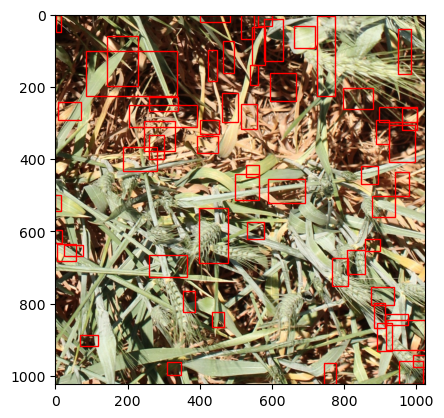

1038
da9846512ff19b8cd7278c8c973f75d36de8c4eb4e593b8285f6821aae1f4203.png


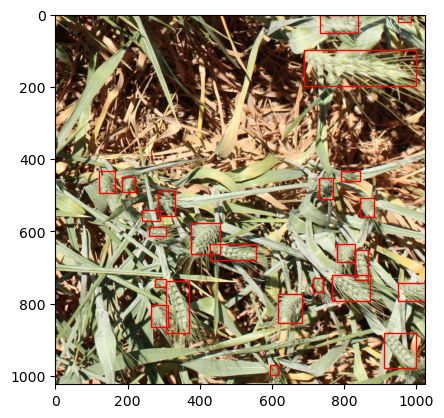

In [158]:
"""
Duplicates to drop are handpicked as there is no easy programatical way
to determine which of two or more duplicates is the correct one.
"""
for row in test_df_dups.sort_values(by=['image_name']).iterrows():
    print(row[0])
    print(row[1]['image_name'])
    img_path = os.path.join(DATASET_ROOT_DIR, 'images', row[1]['image_name'])
    img = Image.open(img_path)
    draw_bboxes(img, row[1]['BoxesString'])
test_df_drop_targets = [911]

2079
1961bcf453d5b2206c428c1c14fe55d1f26f3c655db0a2b6a83094476e8edb5b.png


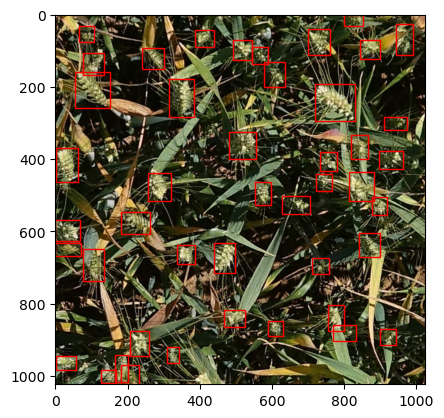

1999
1961bcf453d5b2206c428c1c14fe55d1f26f3c655db0a2b6a83094476e8edb5b.png


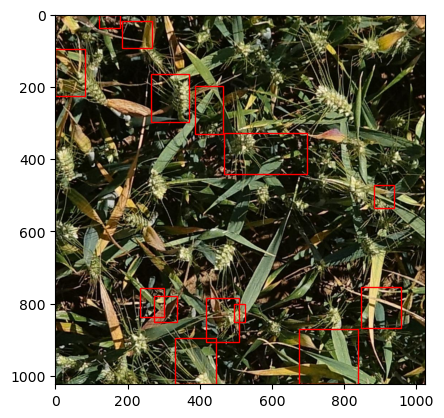

2070
d88963636d49127bda0597ef73f1703e92d6f111caefc44902d5932b8cd3fa94.png


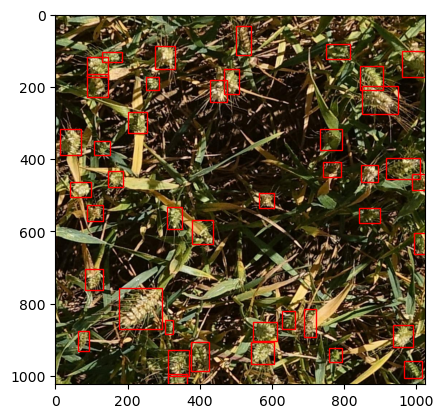

1986
d88963636d49127bda0597ef73f1703e92d6f111caefc44902d5932b8cd3fa94.png


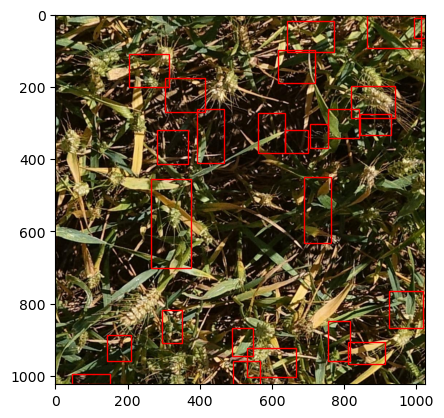

In [159]:
for row in train_df_dups.sort_values(by=['image_name']).iterrows():
    print(row[0])
    print(row[1]['image_name'])
    img_path = os.path.join(DATASET_ROOT_DIR, 'images', row[1]['image_name'])
    img = Image.open(img_path)
    draw_bboxes(img, row[1]['BoxesString'])
train_df_drop_targets = [1999, 1986]

In [160]:
"""
Drop duplicates. Handpicked to drop only ones that have incorrect labels
"""
train_df = train_df.drop(train_df_drop_targets)
test_df = test_df.drop(test_df_drop_targets)

In [161]:
"""
Check if there is leak between train, test and val sets. At this point we are sure that
there are no duplicates in each subset.
"""
df = pd.concat([train_df, test_df, val_df]).reset_index()
import numpy as np
leaks = np.array([])
if not df['image_name'].nunique() == df.shape[0]:
    leaks = df.loc[df.duplicated(subset=['image_name'])]['image_name']
    leaks = leaks.reset_index(drop=True)
print(f"Found {leaks.shape[0]} leaks in the dataset")

Found 0 leaks in the dataset


In [164]:
import numpy as np

"""
Check if there are any duplicate bboxes in the dataset per image. If there are remove them.
"""
for subset_df in [train_df, test_df, val_df]:
    for row in subset_df.iterrows():
        if row[1]['BoxesString'] == 'no_box':
            continue
        bboxes = row[1]['BoxesString'].split(';')
        bboxes = [bbox.split(' ') for bbox in bboxes]
        bboxes = [[int(i) for i in bbox] for bbox in bboxes]
        bboxes = np.array(bboxes, dtype=int)
        uniques, count = np.unique(bboxes, axis=0, return_counts=True)
        duplicate_bboxes = uniques[count > 1]
        if duplicate_bboxes.size > 0:
            print(f"Duplicate boxes found for {row[1]['image_name']}:\n{duplicate_bboxes}")
            new_bboxes_string = ';'.join(' '.join(unique_bbox.astype(str)) for unique_bbox in uniques)
            row[1]['BoxesString'] = new_bboxes_string
            print(f"New duplicate-free BoxesString:\n{new_bboxes_string}")

In [ ]:
"""
Save corrected label files back to csv
"""
train_df.to_csv(f'{DATASET_ROOT_DIR}/competition_train.csv', index=False)
test_df.to_csv(f'{DATASET_ROOT_DIR}/competition_test.csv', index=False)
val_df.to_csv(f'{DATASET_ROOT_DIR}/competition_val.csv', index=False)